# 第13章 ニューラルネットワーク

- 著者オリジナル: https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch13/ch13.ipynb
- Theano を使って最適化された機械学習コードを作成する
  - http://deeplearning.net/software/theano/
- 人工ニューラルネットワークの活性化関数を選択する
- すばやく簡単に実験を行うためにディープラーニングライブラリ Keras を使用する
  - https://keras.io/ , https://keras.io/ja/
  
## 13.1 Theano を使った式の構築、コンパイル、実行

### 13.1.1 Theano とは何か

### 13.1.2 はじめてのTheano

```
$ pip install Theano
```

In [1]:
import theano
from theano import tensor as T

# 初期化: scalar メソッドではスカラー(単純な配列)を生成
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# コンパイル
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 実行
net_input(2.0, 1.0, 0.5)

array(2.5)

### 13.1.3 Theano を設定する

In [9]:
# 浮動小数点数の型のデフォルトを確認
print(theano.config.floatX)

# 浮動小数点数の型を float32 に設定
# GPU の場合は float32 にしないといけないらしい
theano.config.floatX = 'float32'

# CPU と GPU どっちを使うかの設定を確認
print(theano.config.device)

float32
cpu


- 環境変数で設定の変更が可能

```
export THEANO_FLAGS=floatX=float32
```

- cpuを使って計算する場合

```
THEANO_FLAGS=device=cpu,floatX=float64 python <pythonスクリプト>
```

- gpuを使う場合

```
THEANO_FLAGS=device=gpu,floatX=float32 python <pythonスクリプト>
```

- ~/.theanorc ファイルにデフォルト設定を書くことも可能

```
[global]
floatX=float32
device-gpu
```

### 13.1.4 配列構造を操作する

In [12]:
import numpy as np

# 初期化
# Theanoを64ビットモードで実行している場合は、fmatrixの代わりにdmatrixを使用する必要がある
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# コンパイル
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# 実行(Pythonリスト)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

# 実行(Numpy配列)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [15]:
import theano
from theano import tensor as T

# 初期化
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# 実行
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z{}:'.format(i), net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [17]:
import theano
from theano import tensor as T

# 初期化
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# 実行
for i in range(5):
    print('z{}:'.format(i), net_input())

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


### 13.1.5 線形回帰の例

In [18]:
import numpy as np
# 10個のトレーニングサンプルが含まれた、1次元のデータセットを作成する
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

In [29]:
import theano
from theano import tensor as T
import numpy as np

def training_linreg(X_train, y_train, eta, epochs):
    costs = []
    # 配列の初期化
    eta0 = T.fscalar('eta0') # float32型のスカラーのインスタンス
    y = T.fvector(name='y') # float32型のベクトルのインスタンス
    X = T.fmatrix(name='X') # float32型の行列のインスタンス
    # 重み w を関数内で参照可能な共有変数として作成
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1), dtype=theano.config.floatX), name='w')
    
    # コストの計算
    net_input = T.dot(X, w[1:]) + w[0] # 重みを用いて総入力を計算
    errors = y - net_input # yと総入力の誤差
    cost = T.sum(T.pow(errors, 2)) # 誤差との2重和
    
    # 重みの更新
    gradient = T.grad(cost, wrt=w) # コストの勾配
    update = [(w, w - eta0 * gradient)] # コストの勾配に学習率をかけて、重み w を更新
    
    # モデルのコンパイル
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X: X_train, y: y_train})
    
    for _ in range(epochs):
        costs.append(train(eta))
        
    return costs, w

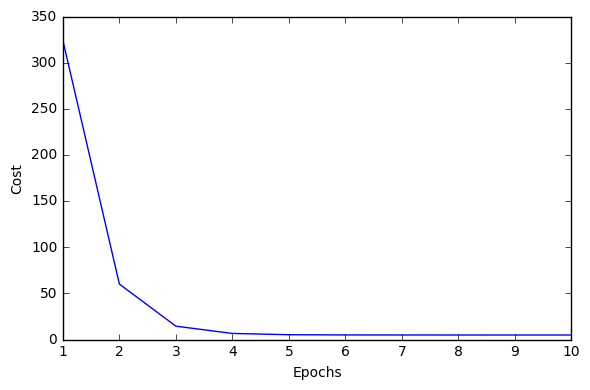

In [30]:
import matplotlib.pyplot as plt
costs, w = training_linreg(X_train, y_train, eta=0.001, epochs=10)

plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()